# Mempersiapkan Data

### Deskripsi Data

SIM	--> 0 : Tidak punya SIM 1 : Punya SIM<br>
Kode_Daerah --> Kode area tempat tinggal pelanggan<br>
Sudah_Asuransi --> 1 : Pelanggan sudah memiliki asuransi kendaraan, 0 : Pelanggan belum memiliki asuransi kendaraan<br>
Umur_Kendaraan --> Umur kendaraan<br>
Kendaraan_Rusak --> 1 : Kendaraan pernah rusak sebelumnya. 0 : Kendaraan belum pernah rusak.<br>
Premi --> Jumlah premi yang harus dibayarkan per tahun.<br>
Kanal_Penjualan --> Kode kanal untuk menghubungi pelanggan (email, telpon, dll)<br>
Lama_Berlangganan	--> Sudah berapa lama pelanggan menjadi klien perusahaan<br>
Tertarik --> 1 : Pelanggan tertarik, 0 : Pelanggan tidak tertarik
<br>

### Import Library

In [ ]:
!pip install category-encoders

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from category_encoders import *
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split


In [ ]:
# Set seed untuk mendapatkan reproducible result
def set_seed(s):
  os.environ['PYTHONHASHSEED']=str(s)
  random.seed(s)
  np.random.seed(s)

### Load Datasets

In [ ]:
path = "/content/drive/MyDrive/Semester 5/Pembelajaran Mesin/Tugas II"

In [ ]:
dftrain = pd.read_csv(path+"/kendaraan_train.csv")
dftest = pd.read_csv(path+"/kendaraan_test.csv")

## Exploratory Data Analysis

### Melihat Cuplikan Data

In [ ]:
df = dftrain.copy()

In [ ]:
df.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


### Melihat Informasi pada Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285831 entries, 0 to 285830
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 285831 non-null  int64  
 1   Jenis_Kelamin      271391 non-null  object 
 2   Umur               271617 non-null  float64
 3   SIM                271427 non-null  float64
 4   Kode_Daerah        271525 non-null  float64
 5   Sudah_Asuransi     271602 non-null  float64
 6   Umur_Kendaraan     271556 non-null  object 
 7   Kendaraan_Rusak    271643 non-null  object 
 8   Premi              271262 non-null  float64
 9   Kanal_Penjualan    271532 non-null  float64
 10  Lama_Berlangganan  271839 non-null  float64
 11  Tertarik           285831 non-null  int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 26.2+ MB


### Deteksi Missing Value

#### Menggunakan missingno library untuk melihat persebaran data yang hilang (missing value)

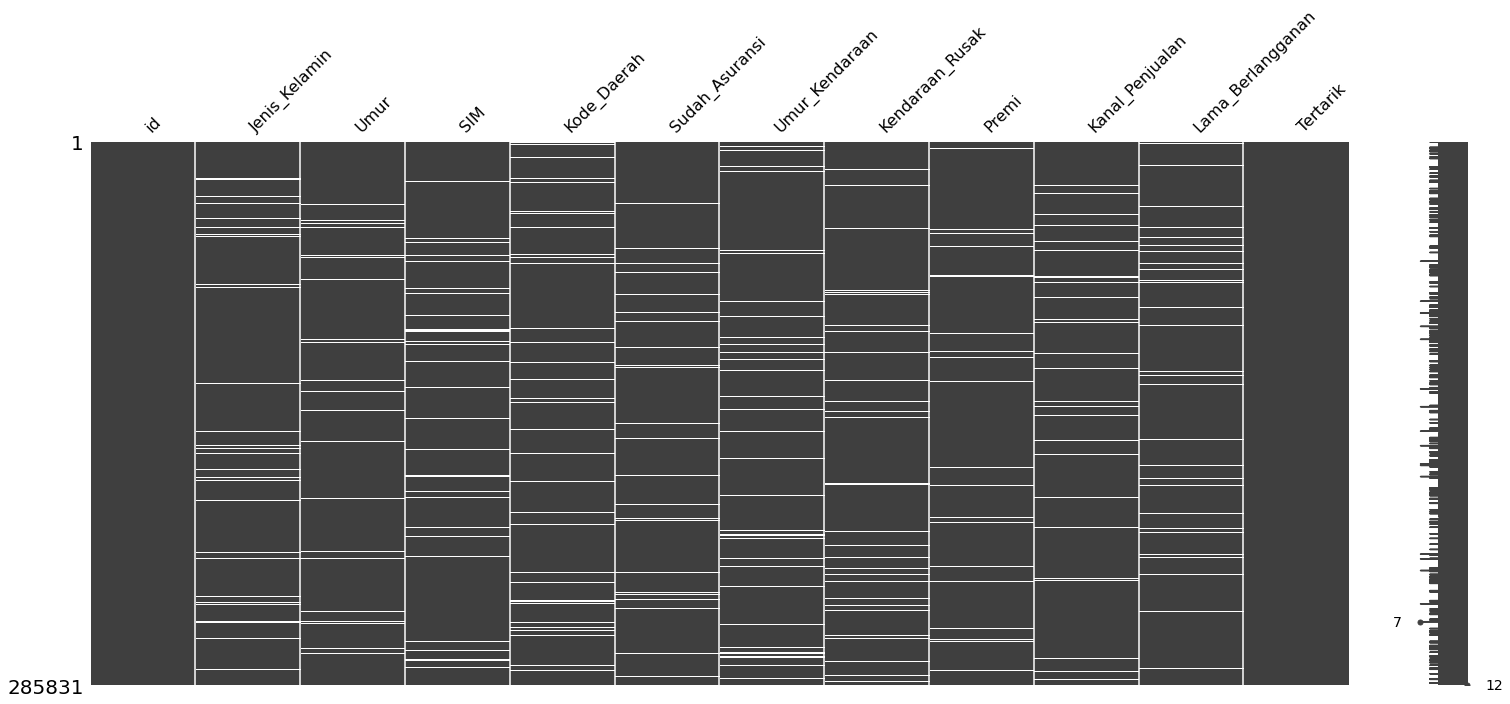

In [ ]:
msno.matrix(df)

Melihat secara presisi berapa ukuran dari data training

In [ ]:
df.shape

(285831, 12)

Data yang kita dapat cukup banyak, lalu kita lihat seberapa banyak missing value pada setiap kolomnya

In [ ]:
df.isna().sum()

id                       0
Jenis_Kelamin        14440
Umur                 14214
SIM                  14404
Kode_Daerah          14306
Sudah_Asuransi       14229
Umur_Kendaraan       14275
Kendaraan_Rusak      14188
Premi                14569
Kanal_Penjualan      14299
Lama_Berlangganan    13992
Tertarik                 0
dtype: int64

In [ ]:
df.nunique()

id                   285831
Jenis_Kelamin             2
Umur                     66
SIM                       2
Kode_Daerah              53
Sudah_Asuransi            2
Umur_Kendaraan            3
Kendaraan_Rusak           2
Premi                 45114
Kanal_Penjualan         151
Lama_Berlangganan       290
Tertarik                  2
dtype: int64

Persebaran kelas label begitu timpang, maka akan dilakukan pula Synthetic Minority Over-sampling Technique (SMOTE) untuk menangani data yang imbalance.

## Prapemrosesan

### Drop NaN value

In [ ]:
df = df.dropna()

In [ ]:
print("Jumlah data setelah di-drop sebanyak : "+str(df.shape[0]))

Jumlah data setelah di-drop sebanyak : 171068


In [ ]:
print("Baris yang di-drop sebanyak : "+ str(int(100*(285831-171068)/285831)) + " persen")

Baris yang di-drop sebanyak : 40 persen


### Drop Kolom id

In [ ]:
df = df.drop(['id'], axis=1)

### Persebaran Kelas Label

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'sampel')

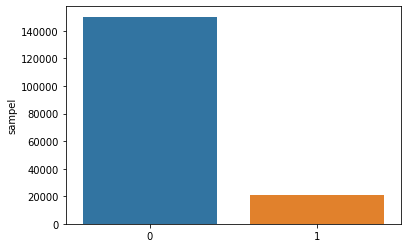

In [ ]:
x=df.Tertarik.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('sampel')

### Handling Ouliers

### Mengubah Semua data menjadi Numerik (Hanya untuk Keperluan Boxplotting)

In [ ]:
def convert_category(dfraw):
  cat = dfraw.unique()
  i2c = {}
  c2i = {}
  for i, v in enumerate(cat):
    i2c[i] = v
    c2i[v] = i
  return i2c, c2i

In [ ]:
def apply_transform(dfraw, col):
  cache = {}
  for x in col:
    i2c, c2i = convert_category(dfraw[x])
    dfraw[x] = dfraw[x].apply(lambda x: float(c2i[x]))
    cache[x] = (i2c, c2i)
  return dfraw, cache

In [ ]:
col = ["Jenis_Kelamin", "Umur_Kendaraan", "Kendaraan_Rusak"]
cache = {}
df, cache = apply_transform(df, col)

In [ ]:
df.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,0.0,30.0,1.0,33.0,1.0,0.0,0.0,28029.0,152.0,97.0,0
1,2,1.0,48.0,1.0,39.0,0.0,1.0,1.0,25800.0,29.0,158.0,0
3,4,0.0,58.0,1.0,48.0,0.0,2.0,0.0,2630.0,124.0,63.0,0
5,6,1.0,21.0,1.0,35.0,1.0,0.0,0.0,22735.0,152.0,171.0,0
8,9,0.0,20.0,1.0,8.0,1.0,0.0,0.0,30786.0,160.0,31.0,0


In [ ]:
cache

{'Jenis_Kelamin': ({0: 'Wanita', 1: 'Pria'}, {'Pria': 1, 'Wanita': 0}),
 'Kendaraan_Rusak': ({0: 'Tidak', 1: 'Pernah'}, {'Pernah': 1, 'Tidak': 0}),
 'Umur_Kendaraan': ({0: '< 1 Tahun', 1: '> 2 Tahun', 2: '1-2 Tahun'},
  {'1-2 Tahun': 2, '< 1 Tahun': 0, '> 2 Tahun': 1})}

#### Boxplotting

In [ ]:
kolom = df.columns[:-1]

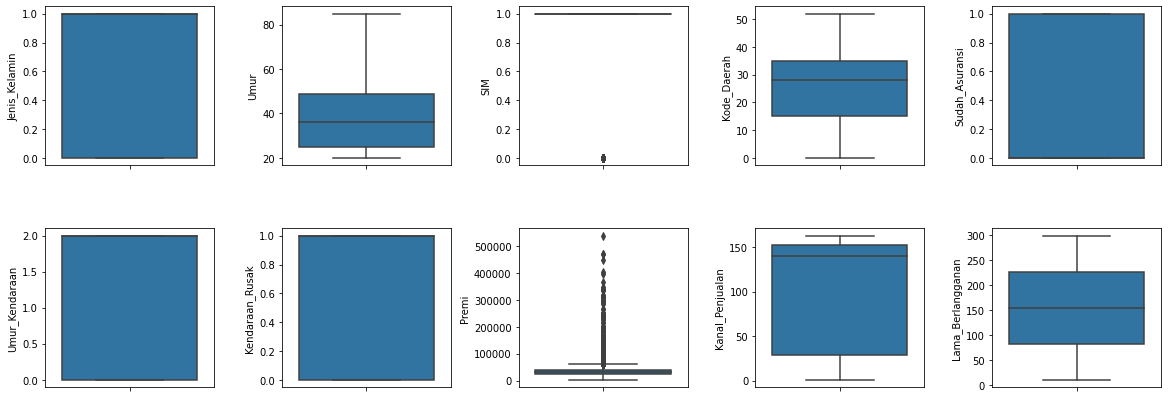

In [ ]:
f, axes = plt.subplots(2, 5, figsize=(20,7), gridspec_kw={'wspace': 0.4,'hspace': 0.4})

for i, v in enumerate(kolom):
  if i < 5:
    sns.boxplot(y=df[v], orient='v' , ax=axes[0][i])
  else:
    sns.boxplot(y=df[v], orient='v' , ax=axes[1][i%5])

#### Melihat deskripsi data

In [ ]:
df.describe()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
count,171068.000000,171068.000000,171068.000000,171068.000000,171068.000000,171068.000000,171068.000000,171068.000000,171068.000000,171068.000000,171068.000000
mean,0.540662,38.818137,0.997931,26.411334,0.459794,1.090204,0.504443,30506.747282,112.260206,154.253063,0.121577
std,0.498345,15.531695,0.045443,13.262377,0.498382,0.974648,0.499982,17090.409733,54.106712,83.862579,0.326798
min,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,0.000000,25.000000,1.000000,15.000000,0.000000,0.000000,0.000000,24369.750000,29.000000,81.000000,0.000000
50%,1.000000,36.000000,1.000000,28.000000,0.000000,2.000000,1.000000,31603.000000,140.000000,154.000000,0.000000
75%,1.000000,49.000000,1.000000,35.000000,1.000000,2.000000,1.000000,39323.250000,152.000000,227.000000,0.000000
max,1.000000,85.000000,1.000000,52.000000,1.000000,2.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


#### Analisis

Pada data yang kita olah, **tidak terdapat outlier**. Walaupun data premi pada boxplot menunjukkan banyak titik-titik di luar plot, namun kita pahami bersama bahwa premi merupakan jumlah premi yang harus dibayarkan per tahun. Tentu saja bisa terjadi banyak data yang distribusinya beda, karena memang bisa saja setiap orang memiliki banyak produk asuransi yang berbeda, bahkan perbedaannya bisa signifikan. Oleh karena itu, bisa dinyatakan bahwa karakteristik data premi itu sendiri di dunia nyata merupakan sesuatu yang bukan anomali/outlier. Alasan yang sama dengan kolom SIM, bukanlah outlier karena tidak memiliki SIM bukanlah suatu anomali.

# Data tanpa Proses Encoding

In [ ]:
dfw_enc = dftrain.copy()
dfw_enc = dfw_enc.dropna()
dfw_enc = dfw_enc.drop("id", axis=1)
dfw_enc.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
3,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
5,Pria,21.0,1.0,35.0,1.0,< 1 Tahun,Tidak,22735.0,152.0,171.0,0
8,Wanita,20.0,1.0,8.0,1.0,< 1 Tahun,Tidak,30786.0,160.0,31.0,0


In [ ]:
dftw_enc = dftest.copy()
dftw_enc.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,Wanita,49,1,8,0,1-2 Tahun,Pernah,46963,26,145,0
1,Pria,22,1,47,1,< 1 Tahun,Tidak,39624,152,241,0
2,Pria,24,1,28,1,< 1 Tahun,Tidak,110479,152,62,0
3,Pria,46,1,8,1,1-2 Tahun,Tidak,36266,124,34,0
4,Pria,35,1,23,0,1-2 Tahun,Pernah,26963,152,229,0


In [ ]:
dfw_enc_ = dfw_enc.drop("Tertarik", axis=1)

In [ ]:
set_seed(42)
xt, xte, yt, yte = train_test_split(dfw_enc_, dfw_enc["Tertarik"], test_size=0.1, random_state=42, stratify=dfw_enc["Tertarik"])

In [ ]:
xt["Tertarik"] = yt

In [ ]:
xte["Tertarik"] = yte

In [ ]:
xt.to_csv(path+"/without encoding/training.csv", index=False)

In [ ]:
xte.to_csv(path+"/without encoding/validation.csv", index=False)

In [ ]:
dftw_enc.to_csv(path+"/without encoding/testing.csv", index=False)

# Data dengan Proses Encoding

### Count Encoding

In [ ]:
col = ["Jenis_Kelamin", "Umur_Kendaraan", "Kendaraan_Rusak"]
Xt_count = xt.drop("Tertarik", axis=1)
cache = {}
Xt_count, cache = apply_transform(Xt_count, col)
Xt_count["Tertarik"] = yt.copy()
Xt_count

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
116604,0.0,52.0,1.0,18.0,0.0,0.0,0.0,2630.0,156.0,143.0,1
220399,0.0,28.0,1.0,7.0,1.0,1.0,1.0,35096.0,160.0,38.0,0
148645,0.0,30.0,1.0,9.0,1.0,1.0,1.0,23083.0,152.0,285.0,0
165962,1.0,30.0,1.0,23.0,0.0,1.0,0.0,28020.0,124.0,10.0,0
126368,1.0,35.0,1.0,33.0,1.0,0.0,1.0,2630.0,160.0,205.0,0
...,...,...,...,...,...,...,...,...,...,...,...
88947,1.0,57.0,1.0,24.0,0.0,0.0,0.0,2630.0,157.0,193.0,0
171871,1.0,37.0,1.0,8.0,0.0,0.0,0.0,38069.0,124.0,239.0,0
74871,1.0,59.0,1.0,46.0,0.0,0.0,0.0,25700.0,26.0,86.0,0
128948,1.0,28.0,1.0,2.0,1.0,1.0,1.0,35153.0,152.0,13.0,0


In [ ]:
col = ["Jenis_Kelamin", "Umur_Kendaraan", "Kendaraan_Rusak"]
Xte_count = xte.drop("Tertarik", axis=1)
cache = {}
Xte_count, cache = apply_transform(Xte_count, col)
Xte_count["Tertarik"] = yte.copy()
Xte_count

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
82258,0.0,25.0,1.0,16.0,0.0,0.0,0.0,25532.0,152.0,295.0,0
9352,0.0,22.0,1.0,30.0,1.0,0.0,1.0,25192.0,152.0,294.0,0
189303,0.0,30.0,1.0,28.0,0.0,1.0,0.0,34740.0,26.0,189.0,1
246491,0.0,65.0,1.0,8.0,0.0,1.0,0.0,58476.0,26.0,178.0,0
22517,0.0,42.0,1.0,6.0,0.0,1.0,0.0,30407.0,26.0,294.0,1
...,...,...,...,...,...,...,...,...,...,...,...
117582,0.0,30.0,1.0,41.0,1.0,0.0,1.0,41656.0,152.0,193.0,0
178734,0.0,46.0,1.0,35.0,1.0,1.0,1.0,36460.0,124.0,173.0,0
187963,1.0,22.0,1.0,38.0,1.0,0.0,1.0,44224.0,152.0,51.0,0
190564,0.0,31.0,1.0,46.0,0.0,0.0,1.0,22097.0,152.0,155.0,0


In [ ]:
col = ["Jenis_Kelamin", "Umur_Kendaraan", "Kendaraan_Rusak"]
Xtest_count = dftw_enc.drop("Tertarik", axis=1)
cache = {}
Xtest_count, cache = apply_transform(Xtest_count, col)
Xtest_count["Tertarik"] = dftw_enc["Tertarik"]
Xtest_count

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0.0,49,1,8,0,0.0,0.0,46963,26,145,0
1,1.0,22,1,47,1,1.0,1.0,39624,152,241,0
2,1.0,24,1,28,1,1.0,1.0,110479,152,62,0
3,1.0,46,1,8,1,0.0,1.0,36266,124,34,0
4,1.0,35,1,23,0,0.0,0.0,26963,152,229,0
...,...,...,...,...,...,...,...,...,...,...,...
47634,1.0,61,1,46,0,2.0,0.0,31039,124,67,0
47635,1.0,41,1,15,0,0.0,0.0,2630,157,232,0
47636,1.0,24,1,29,1,1.0,1.0,33101,152,211,0
47637,1.0,59,1,30,0,0.0,0.0,37788,26,239,1


In [ ]:
#Xt_count.to_csv(path+"/encoded/count encoding/training.csv", index=False)
#Xte_count.to_csv(path+"/encoded/count encoding/validation.csv", index=False)
#Xtest_count.to_csv(path+"/encoded/count encoding/testing.csv", index=False)

## Target Encoding

In [ ]:
bunch = dftrain.copy()
bunch = bunch.dropna()
bunch = bunch.drop("id", axis=1)
y = bunch.Tertarik
X = bunch.drop("Tertarik", axis=1)
enc = TargetEncoder(cols=X.columns).fit(X, y)
numeric_dataset = enc.transform(X)
test = dftest.drop("Tertarik", axis=1)
testing_numeric_dataset = enc.transform(test)

In [ ]:
set_seed(42)
qt, qte, wt, wte = train_test_split(numeric_dataset, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
qt["Tertarik"] = wt
qte["Tertarik"] = wte
testing_numeric_dataset["Tertarik"] = dftest["Tertarik"]

In [ ]:
qt.to_csv(path+"/encoded/training.csv", index=False)
qte.to_csv(path+"/encoded/validation.csv", index=False)
testing_numeric_dataset.to_csv(path+"/encoded/testing.csv", index=False)

# Synthetic Minority Over-sampling Technique (SMOTE) pada Data Training

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)

### Data with Count Encoding

In [ ]:
X_train = xt.drop("Tertarik", axis=1)
y_train = yt.copy() 

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

col = ["Jenis_Kelamin", "Umur_Kendaraan", "Kendaraan_Rusak"]

cache = {}
X_train, cache = apply_transform(X_train, col)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1': 18718
Before OverSampling, counts of label '0': 135243 

After OverSampling, the shape of train_X: (270486, 10)
After OverSampling, the shape of train_y: (270486,) 

After OverSampling, counts of label '1': 135243
After OverSampling, counts of label '0': 135243


In [ ]:
X_train_res

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan
0,0.000000,52.000000,1.0,18.000000,0.0,0.0,0.000000,2630.000000,156.000000,143.000000
1,0.000000,28.000000,1.0,7.000000,1.0,1.0,1.000000,35096.000000,160.000000,38.000000
2,0.000000,30.000000,1.0,9.000000,1.0,1.0,1.000000,23083.000000,152.000000,285.000000
3,1.000000,30.000000,1.0,23.000000,0.0,1.0,0.000000,28020.000000,124.000000,10.000000
4,1.000000,35.000000,1.0,33.000000,1.0,0.0,1.000000,2630.000000,160.000000,205.000000
...,...,...,...,...,...,...,...,...,...,...
270481,0.352457,63.950856,1.0,28.000000,0.0,0.0,0.000000,50066.008227,26.000000,152.967091
270482,0.592591,34.629635,1.0,28.000000,0.0,0.0,0.592591,2630.000000,156.814817,255.777774
270483,0.924620,54.226140,1.0,28.075380,0.0,0.0,0.000000,2630.000000,26.000000,32.623100
270484,1.000000,34.992599,1.0,18.074005,0.0,0.0,0.000000,2630.000000,26.000000,76.022202


In [ ]:
def make_int(dat):
    if dat > 0.5:
        return 1
    else:
        return 0

In [ ]:
X_train_res.Jenis_Kelamin = X_train_res.Jenis_Kelamin.apply(make_int)

In [ ]:
X_train_res.Sudah_Asuransi= X_train_res.Sudah_Asuransi.apply(make_int)

In [ ]:
X_train_res.Umur_Kendaraan= X_train_res.Umur_Kendaraan.apply(make_int)

In [ ]:
for i in X_train_res.columns:
    X_train_res[i] = X_train_res[i].apply(lambda x: int(x))

In [ ]:
X_train_res["Tertarik"] = y_train_res

### Data without Encoding

In [ ]:
cache

{'Jenis_Kelamin': ({0: 'Wanita', 1: 'Pria'}, {'Pria': 1, 'Wanita': 0}),
 'Kendaraan_Rusak': ({0: 'Pernah', 1: 'Tidak'}, {'Pernah': 0, 'Tidak': 1}),
 'Umur_Kendaraan': ({0: '1-2 Tahun', 1: '< 1 Tahun', 2: '> 2 Tahun'},
  {'1-2 Tahun': 0, '< 1 Tahun': 1, '> 2 Tahun': 2})}

In [ ]:
col = ["Jenis_Kelamin", "Umur_Kendaraan", "Kendaraan_Rusak"]

In [ ]:
def inverse_transform(dfraw, col, cache):
  for x in col:
    i2c, _ = cache[x]
    dfraw[x] = dfraw[x].apply(lambda x: i2c[x])
  return dfraw

In [ ]:
Xw_train_res = inverse_transform(X_train_res, col, cache)

In [ ]:
Xw_train_res

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,Wanita,52,1,18,0,1-2 Tahun,Pernah,2630,156,143,1
1,Wanita,28,1,7,1,< 1 Tahun,Tidak,35096,160,38,0
2,Wanita,30,1,9,1,< 1 Tahun,Tidak,23083,152,285,0
3,Pria,30,1,23,0,< 1 Tahun,Pernah,28020,124,10,0
4,Pria,35,1,33,1,1-2 Tahun,Tidak,2630,160,205,0
...,...,...,...,...,...,...,...,...,...,...,...
270481,Wanita,63,1,28,0,1-2 Tahun,Pernah,50066,26,152,1
270482,Pria,34,1,28,0,1-2 Tahun,Pernah,2630,156,255,1
270483,Pria,54,1,28,0,1-2 Tahun,Pernah,2630,26,32,1
270484,Pria,34,1,18,0,1-2 Tahun,Pernah,2630,26,76,1


### Data with Target Encoding

In [ ]:
bunch = X_train_res.copy()
bunch = bunch.dropna()
y = bunch.Tertarik
X = bunch.drop("Tertarik", axis=1)
enc = TargetEncoder(cols=X.columns).fit(X, y)
numeric_dataset = enc.transform(X)

In [ ]:
dftrain = numeric_dataset.copy()

In [ ]:
dftrain["Tertarik"] = y

In [ ]:
dfvalid = pd.read_csv("/content/drive/MyDrive/Semester 5/Pembelajaran Mesin/Tugas II/encoded/count encoding/validation.csv")

In [ ]:
valid = dfvalid.drop("Tertarik", axis=1)
x_val = enc.transform(valid)
x_val["Tertarik"] = dfvalid["Tertarik"]

In [ ]:
x_val

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0.451185,0.180804,0.500165,0.693656,0.676152,0.591941,0.693890,0.500000,0.097198,0.392185,0
1,0.451185,0.143065,0.500165,0.417901,0.006215,0.591941,0.006579,0.856260,0.097198,0.403822,0
2,0.451185,0.518990,0.500165,0.560677,0.676152,0.358731,0.693890,0.598201,0.612856,0.520679,1
3,0.451185,0.381401,0.500165,0.240496,0.676152,0.358731,0.693890,0.500000,0.612856,0.490868,0
4,0.451185,0.676347,0.500165,0.319861,0.676152,0.358731,0.693890,0.749996,0.612856,0.403822,1
...,...,...,...,...,...,...,...,...,...,...,...
17102,0.451185,0.518990,0.500165,0.289346,0.006215,0.591941,0.006579,0.599988,0.097198,0.513078,0
17103,0.451185,0.680398,0.500165,0.506404,0.006215,0.358731,0.006579,0.598201,0.556471,0.475463,0
17104,0.536512,0.143065,0.500165,0.741690,0.006215,0.591941,0.006579,0.500000,0.097198,0.527835,0
17105,0.451185,0.580342,0.500165,0.257114,0.676152,0.591941,0.006579,0.353200,0.097198,0.511351,0


In [ ]:
# x_val.to_csv("/content/drive/MyDrive/Semester 5/Pembelajaran Mesin/Tugas II/encoded/validation.csv",index=False)

In [ ]:
dftest = pd.read_csv("/content/drive/MyDrive/Semester 5/Pembelajaran Mesin/Tugas II/encoded/count encoding/testing.csv")

In [ ]:
test = dfvalid.drop("Tertarik", axis=1)
x_test = enc.transform(test)
x_test["Tertarik"] = dftest["Tertarik"]

In [ ]:
x_test

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0.451185,0.180804,0.500165,0.693656,0.676152,0.591941,0.693890,0.500000,0.097198,0.392185,0
1,0.451185,0.143065,0.500165,0.417901,0.006215,0.591941,0.006579,0.856260,0.097198,0.403822,0
2,0.451185,0.518990,0.500165,0.560677,0.676152,0.358731,0.693890,0.598201,0.612856,0.520679,0
3,0.451185,0.381401,0.500165,0.240496,0.676152,0.358731,0.693890,0.500000,0.612856,0.490868,0
4,0.451185,0.676347,0.500165,0.319861,0.676152,0.358731,0.693890,0.749996,0.612856,0.403822,0
...,...,...,...,...,...,...,...,...,...,...,...
17102,0.451185,0.518990,0.500165,0.289346,0.006215,0.591941,0.006579,0.599988,0.097198,0.513078,0
17103,0.451185,0.680398,0.500165,0.506404,0.006215,0.358731,0.006579,0.598201,0.556471,0.475463,0
17104,0.536512,0.143065,0.500165,0.741690,0.006215,0.591941,0.006579,0.500000,0.097198,0.527835,0
17105,0.451185,0.580342,0.500165,0.257114,0.676152,0.591941,0.006579,0.353200,0.097198,0.511351,0


In [ ]:
#x_test.to_csv("/content/drive/MyDrive/Semester 5/Pembelajaran Mesin/Tugas II/encoded/testing.csv",index=False)

# TomekLinks UnderSampling

In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='not minority')

In [ ]:
col = ["Jenis_Kelamin", "Umur_Kendaraan", "Kendaraan_Rusak"]

cache = {}
X_train, cache = apply_transform(X_train, col)

In [ ]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

X_tl, y_tl = tl.fit_resample(X_train, y_train.ravel())

print('After UnderSampling, the shape of train_X: {}'.format(X_tl.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_tl.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(y_tl == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_tl == 0)))


Before UnderSampling, counts of label '1': 18718
Before UnderSampling, counts of label '0': 135243 

After UnderSampling, the shape of train_X: (145690, 10)
After UnderSampling, the shape of train_y: (145690,) 

After UnderSampling, counts of label '1': 18718
After UnderSampling, counts of label '0': 126972


In [ ]:
X_tl["Tertarik"] = y_tl

In [ ]:
#X_tl.to_csv("tomek_training.csv", index=False)

In [ ]:
bunch = X_tl.copy()
y = bunch.Tertarik
X = bunch.drop("Tertarik", axis=1)
enc = TargetEncoder(cols=X.columns).fit(X, y)
Xtom_enc = enc.transform(X)

In [ ]:
Xtom_enc["Tertarik"] = y

In [ ]:
Xtom_enc.to_csv("targetencoding_tomek_training.csv", index=False)